In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import torch
from sklearn.metrics import roc_auc_score
import math

In [2]:
#load dict with annotation of binding sites -> uniprot_id: {'site_1' : ['res1', 'res2', ..], ..}
cpath = Path(os.getcwd())
data_path =  cpath.parent / "data" / "protobind_diff/attention"
file_bs = data_path / 'binding_sites_BioLip2.json'
with open(file_bs, "r") as f:
    binding_site_dict = json.load(f)

In [3]:
sequences = np.array(list(binding_site_dict.keys()))

# Collect all binding site residue indices for each sequence into a dictionary

bs_indexes = {}
for seq in sequences:
    indexes = [
        int(re.search(r'\d+', res).group())
        for res_list in binding_site_dict[seq].values()
        for res in res_list
    ]
    bs_indexes[seq] = indexes


In [4]:
# ---- load & restore numpy dict with attention maps  -----------------------------------
loaded = torch.load(data_path / 'preds_active_uid_filtered.pt', map_location='cpu', weights_only=False)
attention_maps = {k: v.numpy() for k, v in loaded.items()}

In [5]:
# Compute metrics based on windowed attention scores.
# Each window takes the max attention score and checks if any true binding site falls within it.
# This treats nearby predictions ("near misses") as correct, making the evaluation more tolerant and realistic.

def window_prediction_metrics(att, binding_site_indices, window_size=10, stride=10):
    active = set(i - 1 for i in binding_site_indices)
    L = len(att)

    # collect all windows
    windows = []
    start = 0
    while start < L:
        end = min(start + window_size, L)     
        score = att[start:end].max()      
        label = any(i in active for i in range(start, end)) 
        windows.append({'score': score, 'label': label})
        start += stride


    df_ = pd.DataFrame(windows)
    len_ = (df_['label'] == 1).sum()
    if len_ == 0:
        print("stop")
    result = {}
    
    result['roc_auc'] = roc_auc_score(df_['label'].to_list(), df_['score'].to_list())
    return result


In [6]:
window_size = 3
n_heads = 8

# Initialize per-head metrics dicts
metrics_by_head = [{} for _ in range(n_heads)]

for uid, attn_heads in attention_maps.items():
    for head_idx in range(n_heads):
        metrics_by_head[head_idx][uid] = window_prediction_metrics(
            attn_heads[head_idx], bs_indexes[uid], window_size, window_size
        )


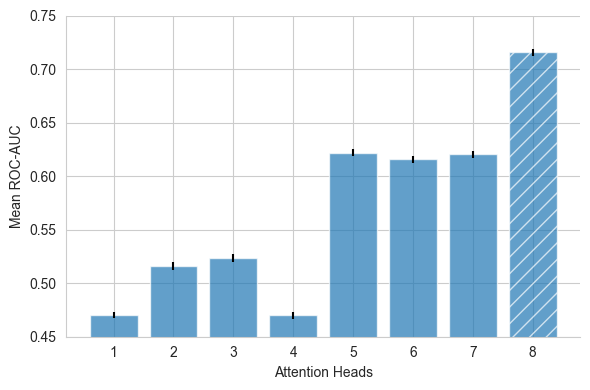

In [7]:
heads      = [f'{i}' for i in range(1, 9)]
dfs        = [pd.DataFrame(d).T for d in metrics_by_head]
mean_auc   = [df['roc_auc'].mean() for df in dfs]
sem_auc    = [df['roc_auc'].std(ddof=1) / math.sqrt(len(df))
              for df in dfs]                   

best_idx   = int(np.argmax(mean_auc))
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(
    heads,
    mean_auc,
    yerr=sem_auc,
    capsize=0,       
    alpha=0.7,
)
bars[best_idx].set_hatch('//') 

ax.set_ylabel('Mean ROC-AUC')
ax.set_xlabel('Attention Heads')
ax.set_ylim(0.45, 0.75)
for spine in ('top', 'right'):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig("attention_windows.png")
plt.show()

